![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [2]:
import warnings
# "filterwarnings" es una función que controla cómo se manejan las advertencias en Python.
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [4]:
# Importación de librerías adicionales
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [6]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [7]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

### Analisis descriptivo

El dataset "bikeShare" contiene datos sobre el alquiler de bicicletas a lo largo del tiempo. Incluye información sobre las condiciones climaticas y factores temporales que pueden incidir en la demanda de bicicletas. El conjunto de datos principales está relacionado con el registro histórico de dos años correspondiente a los años 2011 y 2012 del sistema Capital Bikeshare en Washington D.C. de estados unidos. 

Teniendo en cuenta los resultados obtenidos, la demanda de bicicletas tiene una estacionalidad tanto anual como diaria. La estacion del año influye en el uso de las bicicletas, esto puede deberse al clima y el calendario escolar de estados unidos. Por otro lado, existe una tendencia diara junto con una hora pico al dia donde la demanda de bicicletas es alta. 

Estas primeras observaciones dan lugar a tendencias temporales claras de manera diaria y anual. Estas tendencias se pueden ver reforzadas por datos demograficos o poblacionales de las personas que utilizan el servicio de Bikeshare. Ya que se puede comprobar que las vacaciones escolares es un periodo fundamental para los servicios de prestamo de bicicletas.

In [8]:
# Visualización de los datos
bikes.info()
bikes.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  total       10886 non-null  int64  
 11  hour        10886 non-null  int32  
dtypes: float64(3), int32(1), int64(8)
memory usage: 1.0 MB


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


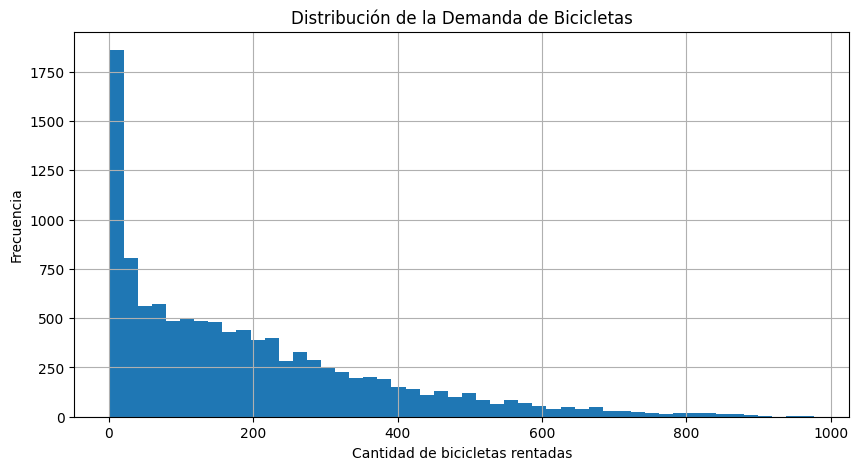

In [9]:
# Graficar la distribución de la demanda de bicicletas
plt.figure(figsize=(10,5))
bikes['total'].hist(bins=50)
plt.title('Distribución de la Demanda de Bicicletas')
plt.xlabel('Cantidad de bicicletas rentadas')
plt.ylabel('Frecuencia')
plt.show()

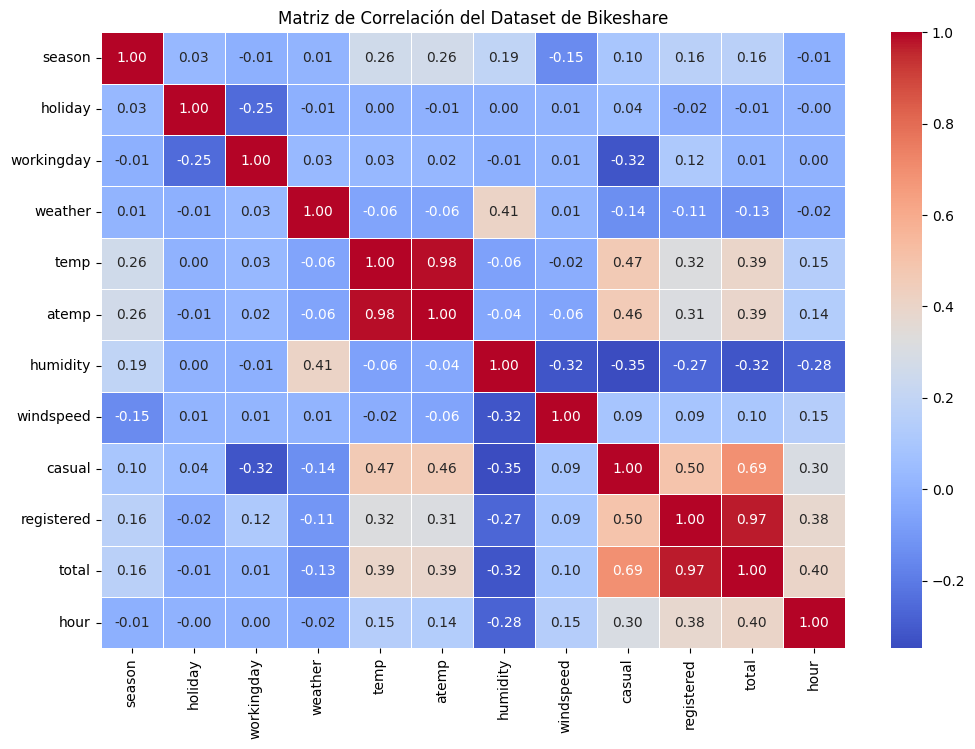

In [10]:
# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(bikes.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación del Dataset de Bikeshare")
plt.show()

### Analisis descriptivo

El dataset "bikeShare" cuenta con 10886 registros, los cuales podemos observar en el histograma de la demanda debicicletas. Se observan datos atipicos con un valor mayor al percentil 75% de 284. Este comportamiento sugiere que hay dias excepcionales donde la demanda de bicicletas aumenta considerablemente, esto puede deberse a las tendencias de la temporalidad y el estado del clima. 

La tendencia demarcada por el estado del clima se puede observar en la grafica de correlacion donde las temperaturas "temp" y "atemp" tienen una correlación positiva con la cantidad total de bicicletas alquiladas, con un valor de 0.39. Esto indica que a temperaturas más altas, hay mayor demanda de bicicletas. De igual menera la variable "humidity" tiene una correlación negativa, ya que los dias de lluvia perjudican el uso de las bicicletas.


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

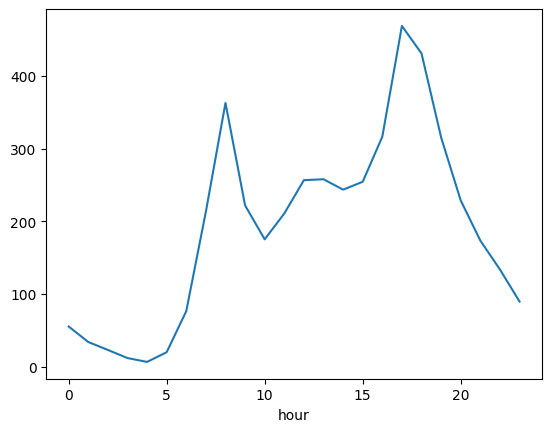

In [11]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

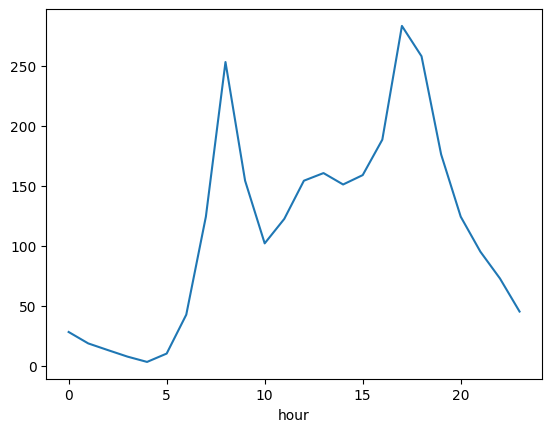

In [12]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes["season"] == 1].groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

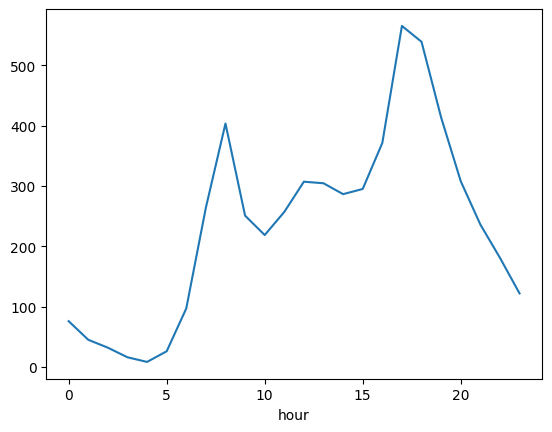

In [13]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes["season"] == 3].groupby('hour').total.mean().plot()

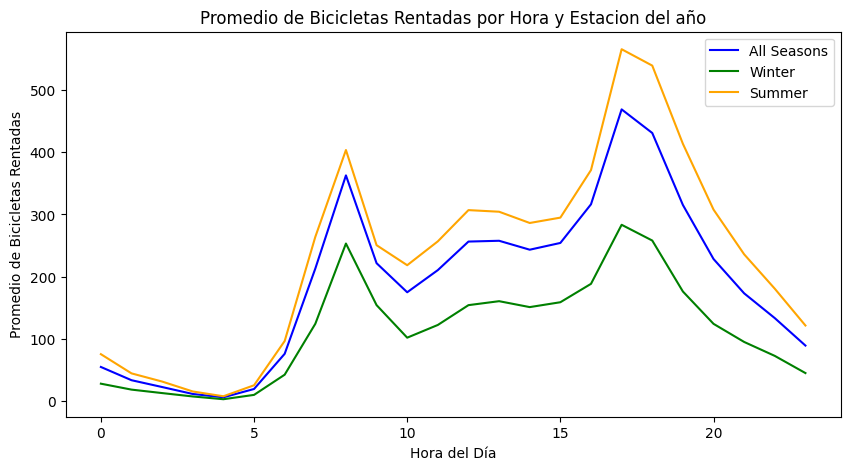

In [14]:
plt.figure(figsize=(10,5))

# Variables para graficar
all_season_data = bikes.groupby('hour').total.mean()
winter_data = bikes[bikes["season"] == 1].groupby('hour').total.mean()
summer_data = bikes[bikes["season"] == 3].groupby('hour').total.mean()

# Comparacion de las estaciones del año
plt.plot(all_season_data, label='All Seasons', color='blue')
plt.plot(winter_data, label='Winter', color='green')
plt.plot(summer_data, label='Summer', color='orange')

plt.title('Promedio de Bicicletas Rentadas por Hora y Estacion del año')
plt.xlabel('Hora del Día')
plt.ylabel('Promedio de Bicicletas Rentadas')
plt.legend()

Como se menciono en puntos anteriores, existe una tendencia dairia y anual para la cantidad de bibicletas prestadas. Se observan resultados esperados, ya que la estacion con el promedio de demanda más alto es verano y la de menor es invierno.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a un conjunto de train de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [15]:
# Celda 3
# Definir variables predictoras y objetivo
X = bikes[["hour", "season"]]
y = bikes['total']

In [16]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [17]:
# Ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [18]:
# Obtener coeficientes
coeficientes = pd.DataFrame(model.coef_, index=X.columns, columns=['Coeficiente'])
intercepto = model.intercept_

print("Intercepto:", intercepto)
print(coeficientes)

Intercepto: -0.4421842506725966
        Coeficiente
hour      10.556160
season    27.577533


#### Interpretación:

Intercepto: Representa el número esperado de bicicletas alquiladas cuando la hour es 0 y la estacion es invierno. 

Coeficiente de hour: Muestra cómo cambia la demanda de bicicletas con cada hora adicional. Cada hora 10 bicicletas son prestadas segun el modelo. 

Coeficientes de season: Representan el cambio en la demanda con respecto a la estacion. Por cada estacion que pasa la demanda de bicicletas incrementa en 27.

In [19]:
# Mostramos los resultados
prediccionLin = model.predict(X_test)
MSELin = np.average(np.square(prediccionLin-y_test))
r2 = r2_score(y_test, prediccionLin)

print(f'MSE: {MSELin:.2f}')
print(f'RMSE: {np.sqrt(MSELin):.2f}')
print(f"R² Score: {r2:.3f}")

MSE: 26572.93
RMSE: 163.01
R² Score: 0.182


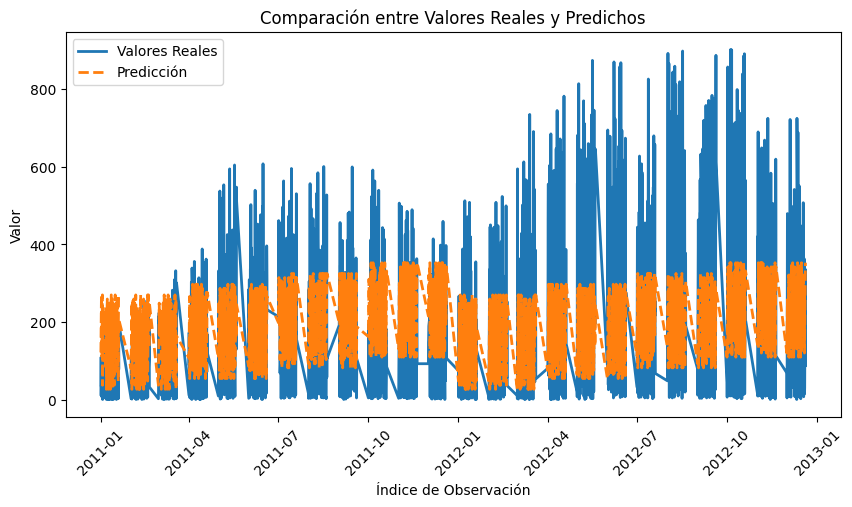

In [20]:
graf = pd.DataFrame({"real": y_test, "predicho": prediccionLin})

plt.figure(figsize=(10, 5))
sns.lineplot(data=graf, x=graf.index, y="real", label="Valores Reales", linewidth=2)
sns.lineplot(data=graf, x=graf.index, y="predicho", label="Predicción", linestyle="dashed", linewidth=2)

plt.xticks(rotation=45)  # Mejora la legibilidad del eje x si es una fecha/hora
plt.xlabel("Índice de Observación")
plt.ylabel("Valor")
plt.title("Comparación entre Valores Reales y Predichos")
plt.legend()
plt.show()

In [21]:
# Serie de pandas para mostrar los resultados de la validadcion cruzada para 10 folds
pd.Series(cross_val_score(model, X, y, cv=10)).describe()

count    10.000000
mean     -0.477070
std       1.555625
min      -4.847897
25%      -0.002359
50%       0.032147
75%       0.119293
max       0.274427
dtype: float64

#### Limitaciones de la regresión lineal en este caso:

Relaciones no lineales: La demanda de bicicletas no varía de manera lineal con la hora del día, como observamops en el punto anterior.

No captura patrones complejos: Factores como el clima, días festivos, dias laborales o tendencias temporales pueden influir y no se están considerando.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [50]:
# Celda 3
# Definir variables predictoras y objetivo
X = bikes[["hour", "season"]]
y = (bikes['total'] > 191).astype(int)  # Convertir a variable binaria

In [51]:
# Celda 4
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [55]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [58]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [60]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [61]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 2)
j, split, gain

(0, np.float64(8.0), np.float64(0.10845540825531091))

In [62]:
# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [63]:
y.shape[0], y_l.shape[0], y_r.shape[0]

(10886, 3594, 7292)

In [64]:
y.mean(), y_l.mean(), y_r.mean()

(np.float64(0.40014697776961233),
 np.float64(0.06844741235392321),
 np.float64(0.5636313768513439))

In [65]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [67]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': 0,
 'y_prob': np.float64(0.400165319617928),
 'level': 0,
 'split': [0, np.float64(8.0)],
 'n_samples': 10886,
 'gain': np.float64(0.10845540825531091),
 'sl': {'y_pred': 0,
  'y_prob': np.float64(0.06868743047830923),
  'level': 1,
  'split': [0, np.float64(7.0)],
  'n_samples': 3594,
  'gain': np.float64(0.05819371744163647),
  'sl': {'y_pred': 0,
   'y_prob': np.float64(0.0038204393505253103),
   'level': 2,
   'split': -1,
   'n_samples': 3139,
   'gain': np.float64(4.785361675416124e-05)},
  'sr': {'y_pred': 1,
   'y_prob': np.float64(0.5164113785557987),
   'level': 2,
   'split': [1, np.float64(2.0)],
   'n_samples': 455,
   'gain': np.float64(0.030716664040954966),
   'sl': {'y_pred': 0,
    'y_prob': np.float64(0.30434782608695654),
    'level': 3,
    'split': -1,
    'n_samples': 113,
    'gain': 0},
   'sr': {'y_pred': 1,
    'y_prob': np.float64(0.5872093023255814),
    'level': 3,
    'split': -1,
    'n_samples': 342,
    'gain': np.float64(0.00277008310249310

In [68]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [70]:
# Ejecución de función tree_predict
yPredict = tree_predict(X, tree)

In [72]:
errorTree = 0
for i in range(0,len(y)):
    if(y[i]!=yPredict[i]):
        errorTree+=1/len(y)
        
print('El error de clasificación es:')
print(errorTree)

El error de clasificación es:
0.19125482270807317


7 nodos finales generados. En el enunciado no se especifica si se debe analizar el rendimiento del arbol creado, solo se observa el error que tiene en la misma muestra de entrenamiento.

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [86]:
# Definir variables predictoras y objetivo
X = bikes[["hour", "season"]]
y = bikes['total']

In [83]:
# Celda 5
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [89]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10).mean())

Text(0, 0.5, 'Accuracy')

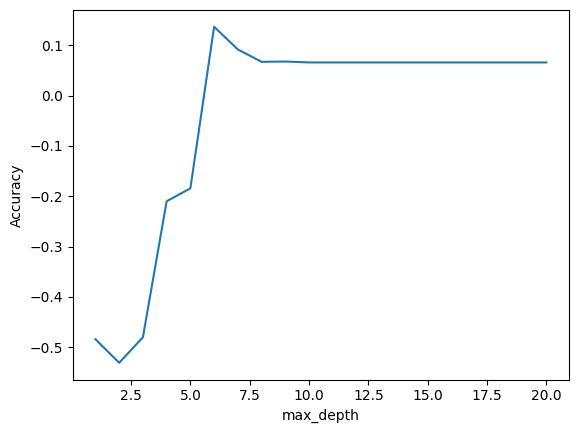

In [90]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [91]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(np.float64(0.1368768537256268), 6)

In [93]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeRegressor(max_depth=6, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, random_state=1)

In [94]:
prediccionesTree=clf.predict(X_test)
MSETREE = np.average(np.square(prediccionesTree-y_test))
r2 = r2_score(y_test, prediccionesTree)

# Mostramos los resultados
print(f'MSE: {MSETREE:.2f}')
print(f'RMSE: {np.sqrt(MSETREE):.2f}')
print(f"R² Score: {r2:.3f}")

MSE: 13472.50
RMSE: 116.07
R² Score: 0.585


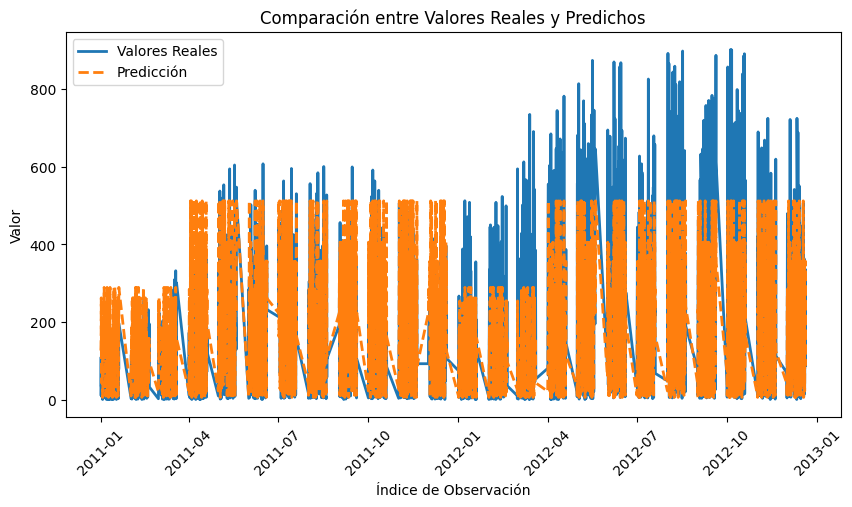

In [95]:
graf = pd.DataFrame({"real": y_test, "predicho": prediccionesTree})

plt.figure(figsize=(10, 5))
sns.lineplot(data=graf, x=graf.index, y="real", label="Valores Reales", linewidth=2)
sns.lineplot(data=graf, x=graf.index, y="predicho", label="Predicción", linestyle="dashed", linewidth=2)

plt.xticks(rotation=45)  # Mejora la legibilidad del eje x si es una fecha/hora
plt.xlabel("Índice de Observación")
plt.ylabel("Valor")
plt.title("Comparación entre Valores Reales y Predichos")
plt.legend()
plt.show()

#### Comparacion de modelos:

El modelo de arbol de decisión tiene mejor desempeño que el modelo de regresion lineal. Las metricas de desempeño utilizadas fueron MSE, RMSE y R2. Todas las metricas mejoraron considerablemente para el modelo de arbol de decisión.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [96]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [97]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

np.float64(0.5)

In [98]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [103]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [104]:
# Celda 6
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [105]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

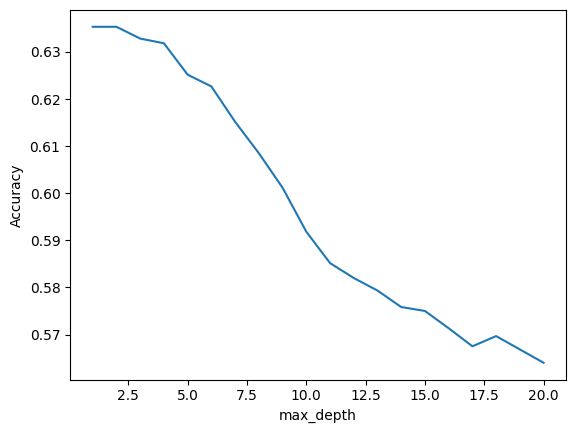

In [106]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [107]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(np.float64(0.6353333333333333), 2)

In [ ]:
# Modelo de arbol de decisión con calibración del hiperparámetro de profundidad
tree_model = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)

# Evaluación de los modelos
accuracy_tree = accuracy_score(y_test, tree_pred)
f1_tree = f1_score(y_test, tree_pred)

In [ ]:

# Modelo de regresión logística
log_reg_model = LogisticRegression(max_iter=500, random_state=0)
log_reg_model.fit(X_train, y_train)
log_reg_pred = log_reg_model.predict(X_test)

accuracy_log_reg = accuracy_score(y_test, log_reg_pred)
f1_log_reg = f1_score(y_test, log_reg_pred)

In [110]:
(accuracy_tree, f1_tree), (accuracy_log_reg, f1_log_reg)

((0.6416666666666667, 0.6398659966499163),
 (0.6177777777777778, 0.6104190260475651))

#### Comparacion de modelos:

El modelo de arbol de decisión tiene mejor desempeño que el modelo de regresion logística. Las metricas de desempeño utilizadas fueron accuracy y F1. Todas las metricas mejoraron para el modelo de arbol de decisión.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [111]:
# Celda 7
# Creación de 100 muestras de bootstrap
n_estimators_1 = 100
n_estimators_2 = 100
n_estimators_3 = 100

n_samples = X_train.shape[0]

np.random.seed(123)
samples_1 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators_1)]

np.random.seed(321)
samples_2 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators_2)]

np.random.seed(132)
samples_3 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators_3)]

In [138]:
# Entrenamiento de 100 modelos con las 100 muestras boostrap
np.random.seed(123) 
seeds_1 = np.random.randint(1, 10000, size=n_estimators_1)

np.random.seed(321)
seeds_2 = np.random.randint(1, 10000, size=n_estimators_2)

np.random.seed(132)
seeds_3 = np.random.randint(1, 10000, size=n_estimators_3)

trees = {}
for i in range(n_estimators_1):
    trees[i] = DecisionTreeClassifier(max_depth=2, min_samples_leaf = 1, random_state=seeds_1[i])
    trees[i].fit(X_train.iloc[samples_1[i]], y_train.iloc[samples_1[i]])

for i in range(n_estimators_2):
    trees[100 + i] = DecisionTreeClassifier(max_depth=None, min_samples_leaf=200, random_state=seeds_2[i])
    trees[100 + i].fit(X_train.iloc[samples_2[i]], y_train.iloc[samples_2[i]])

for i in range(n_estimators_3):
    trees[200 + i] = LogisticRegression(max_iter=500, random_state=seeds_3[i])
    trees[200 + i].fit(X_train.iloc[samples_3[i]], y_train.iloc[samples_3[i]])

In [206]:
# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators_1 + n_estimators_2 + n_estimators_3)))    
for i in range(n_estimators_1 + n_estimators_2 + n_estimators_3):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
4320,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
2006,0,0,0,1,0,0,0,0,0,1,...,1,1,0,0,1,1,1,1,1,1
5689,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
472,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1370,1,1,0,1,1,0,0,0,1,1,...,0,1,1,1,1,1,1,1,1,1


In [140]:
# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= ((n_estimators_1 + n_estimators_2 + n_estimators_3)  / 2)).astype(np.int64)

# Desempeño al hacer votación mayoritaria
from sklearn import metrics
F1_total = metrics.f1_score(y_pred, y_test)
F1_total

0.636519748139668

In [141]:
# Desempeño al hacer votación mayoritaria
acc_total = metrics.accuracy_score(y_pred, y_test)
acc_total

0.6472222222222223

In [142]:
# Filtrar las columnas del DataFrame para incluir solo el rango seleccionado
y_pred_1 = y_pred_df.iloc[:, 0:99]
y_pred_1 = (y_pred_1.sum(axis=1) >= ((n_estimators_1)  / 2)).astype(np.int64)

y_pred_2 = y_pred_df.iloc[:, 100:199]
y_pred_2 = (y_pred_2.sum(axis=1) >= ((n_estimators_2)  / 2)).astype(np.int64)

y_pred_3 = y_pred_df.iloc[:, 200:299]
y_pred_3 = (y_pred_3.sum(axis=1) >= ((n_estimators_3)  / 2)).astype(np.int64)

In [143]:
F1_1 = metrics.f1_score(y_pred_1, y_test)
F1_2 = metrics.f1_score(y_pred_2, y_test)
F1_3 = metrics.f1_score(y_pred_3, y_test)

acc_1 = metrics.accuracy_score(y_pred_1, y_test)
acc_2 = metrics.accuracy_score(y_pred_2, y_test)
acc_3 = metrics.accuracy_score(y_pred_3, y_test)

# Mostramos los resultados
print(f'Modelo 1 => F1: {F1_1:.4f}, Accuracy: {acc_1:.4f}')
print(f'Modelo 2 => F1: {F1_2:.4f}, Accuracy: {acc_2:.4f}')
print(f'Modelo 3 => F1: {F1_3:.4f}, Accuracy: {acc_3:.4f}')

Modelo 1 => F1: 0.6392, Accuracy: 0.6406
Modelo 2 => F1: 0.6634, Accuracy: 0.6611
Modelo 3 => F1: 0.6151, Accuracy: 0.6211


#### Comparación de modelos

Analizando las métricas de F1-Score y Accuracy de los cuatro modelos evaluados, se observa:

- Modelo 2 (Árbol de Decisión con min_samples_leaf = 200) es el más efectivo en términos generales. Obtiene el mayor F1-Score (0.6634) y una Accuracy (0.6611) superior al resto. Un min_samples_leaf igual 200 implica que el árbol evita sobreajustarse a los datos de entrenamiento, lo que podría explicar su mejor generalización.

- El ensamble de todos los modelos no supera al mejor modelo individual. Su F1-Score (0.6365) y Accuracy (0.6472) son mejores que algunos modelos individuales, pero no logra superar al Modelo 2.

Esto sugiere que la combinación de modelos no necesariamente produce un mejor resultado, posiblemente porque algunos modelos individuales están disminuyendo el rendimiento del ensamble.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [144]:
# Celda 8
samples_oob_1 = []
samples_oob_2 = []
samples_oob_3 = []

# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples_1:
    samples_oob_1.append(sorted(set(range(n_samples)) - set(sample)))

for sample in samples_1:
    samples_oob_2.append(sorted(set(range(n_samples)) - set(sample)))

for sample in samples_3:
    samples_oob_3.append(sorted(set(range(n_samples)) - set(sample)))

In [146]:
# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators_1 + n_estimators_2 + n_estimators_3)

for i in range(n_estimators_1):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob_1[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob_1[i]], y_pred_)

for i in range(n_estimators_2):
    y_pred_ = trees[100 + i].predict(X_train.iloc[samples_oob_2[i]])
    errors[100 + i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob_2[i]], y_pred_)

for i in range(n_estimators_3):
    y_pred_ = trees[200 + i].predict(X_train.iloc[samples_oob_3[i]])
    errors[200 + i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob_3[i]], y_pred_)

Text(0.5, 1.0, 'OOB error of each tree')

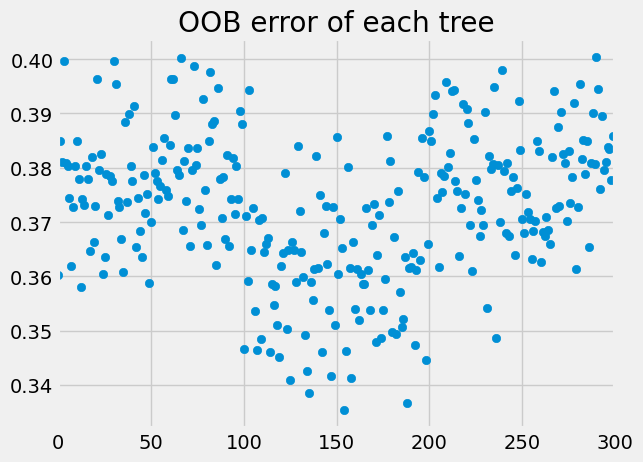

In [147]:
plt.style.use('fivethirtyeight')

plt.scatter(range(n_estimators_1 + n_estimators_2 + n_estimators_3), errors)
plt.xlim([0, n_estimators_1 + n_estimators_2 + n_estimators_3])
plt.title('OOB error of each tree')

In [162]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()

In [171]:
# Ponderación de las predicciones con los pesos alpha
weighted_sum = ((y_pred_df) * alpha).sum(axis=1)

In [172]:
# Desempeño al hacer votación ponderada
y_pred = (weighted_sum >= 0.5).astype(np.int64)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.6361031518624641, 0.6472222222222223)

In [197]:
# Filtrar las columnas del DataFrame para incluir solo el rango seleccionado
y_pred_1 = y_pred_df.iloc[:, 0:99]
alpha_1 = alpha[0:99]
weighted_sum_1 = ((y_pred_1) * alpha_1).sum(axis=1)
y_pred_1 = (weighted_sum_1 >= 0.5).astype(np.int64)

y_pred_2 = y_pred_df.iloc[:, 100:199]
alpha_2 = alpha[100:199]
weighted_sum_2 = ((y_pred_2) * alpha_2).sum(axis=1)
y_pred_2 = (weighted_sum_2 >= 0.5).astype(np.int64)

y_pred_3 = y_pred_df.iloc[:, 200:299]
alpha_3 = alpha[200:299]
weighted_sum_3 = ((y_pred_3) * alpha_3).sum(axis=1)
y_pred_3 = (weighted_sum_3 >= 0.5).astype(np.int64)

In [199]:
F1_1 = metrics.f1_score(y_pred_1, y_test)
F1_2 = metrics.f1_score(y_pred_2, y_test)
F1_3 = metrics.f1_score(y_pred_3, y_test)

acc_1 = metrics.accuracy_score(y_pred_1, y_test)
acc_2 = metrics.accuracy_score(y_pred_2, y_test)
acc_3 = metrics.accuracy_score(y_pred_3, y_test)

# Mostramos los resultados
print(f'Modelo 1 => F1: {F1_1:.4f}, Accuracy: {acc_1:.4f}')
print(f'Modelo 2 => F1: {F1_2:.4f}, Accuracy: {acc_2:.4f}')
print(f'Modelo 3 => F1: {F1_3:.4f}, Accuracy: {acc_3:.4f}')

Modelo 1 => F1: 0.0000, Accuracy: 0.5006
Modelo 2 => F1: 0.0000, Accuracy: 0.5006
Modelo 3 => F1: 0.0000, Accuracy: 0.5006


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

Al aplicar votación ponderada, los Modelos 1, 2 y 3 obtuvieron un F1-Score de 0.0000 y Accuracy de 0.5006, lo que indica que la votación ponderada pudo haber generado predicciones defectuosas o que la asignación de pesos no fue adecuada. Es posible que la ponderación haya anulado la capacidad predictiva de estos modelos al hacer que su impacto en la decisión final fuera mínimo o nulo.

Por otro lado, el Modelo 4 (ensamble con votación ponderada) logró un F1-Score de 0.6361 y Accuracy de 0.6472, lo que sugiere que, a pesar de la falla en la ponderación de los modelos individuales, la combinación general aún retuvo cierto poder predictivo

Se debe realizar una revisión del esquema de votación ponderada, ya que es necesario analizar cómo se calcularon los pesos de cada modelo en la combinación final. Si los modelos individuales terminaron con contribuciones nulas, la votación ponderada no está funcionando correctamente. Esto lo podemos observar ya que los valores obtenidos no superan 0.5. Vemos a continuacion que los modelos tienen una sensibilidad baja al tener que desplazar el limite a 0.3.

In [209]:
# Filtrar las columnas del DataFrame para incluir solo el rango seleccionado
y_pred_1 = y_pred_df.iloc[:, 0:99]
alpha_1 = alpha[0:99]
weighted_sum_1 = ((y_pred_1) * alpha_1).sum(axis=1)
y_pred_1 = (weighted_sum_1 >= 0.3).astype(np.int64)

y_pred_2 = y_pred_df.iloc[:, 100:199]
alpha_2 = alpha[100:199]
weighted_sum_2 = ((y_pred_2) * alpha_2).sum(axis=1)
y_pred_2 = (weighted_sum_2 >= 0.3).astype(np.int64)

y_pred_3 = y_pred_df.iloc[:, 200:299]
alpha_3 = alpha[200:299]
weighted_sum_3 = ((y_pred_3) * alpha_3).sum(axis=1)
y_pred_3 = (weighted_sum_3 >= 0.3).astype(np.int64)

In [210]:
F1_1 = metrics.f1_score(y_pred_1, y_test)
F1_2 = metrics.f1_score(y_pred_2, y_test)
F1_3 = metrics.f1_score(y_pred_3, y_test)

acc_1 = metrics.accuracy_score(y_pred_1, y_test)
acc_2 = metrics.accuracy_score(y_pred_2, y_test)
acc_3 = metrics.accuracy_score(y_pred_3, y_test)

# Mostramos los resultados
print(f'Modelo 1 => F1: {F1_1:.4f}, Accuracy: {acc_1:.4f}')
print(f'Modelo 2 => F1: {F1_2:.4f}, Accuracy: {acc_2:.4f}')
print(f'Modelo 3 => F1: {F1_3:.4f}, Accuracy: {acc_3:.4f}')

Modelo 1 => F1: 0.5727, Accuracy: 0.6261
Modelo 2 => F1: 0.4374, Accuracy: 0.5956
Modelo 3 => F1: 0.5652, Accuracy: 0.6111
